# 🌺 고객 대출등급 분류 해커톤 - FEATURE PREPORCEESING
Evaluation Metric : Macro F1<br>
Public Score : 전체 테스트 데이터 중 30%<br>
Baseline Score : 0.71 적어도 0.8점대로 마감하기!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 1) 수치형 특성 분포 확인

In [5]:
def load_dataset():
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')
    all_df = pd.concat([train,test])
    return all_df

#### - '근로기간' 컬럼 전처리 함수

In [6]:
def to_num(value):
    try:
        return int(value.split()[0])
    except ValueError:
        if value in ('10+ years','10+yea|rs'):
            return 10
        elif value in ('< 1 year','<1 year'):
            return 0
        else:
            return np.nan

def working_period_to_num(df):
    df['근로기간'] = df['근로기간'].apply(to_num)
    # print(df['근로기간'].value_counts(dropna=False))
    return df

In [7]:
df = load_dataset()
df = working_period_to_num(df)

#### - 전체 feature 별 hist

In [27]:
num_col = df.dtypes[df.dtypes != 'object'].index.tolist()

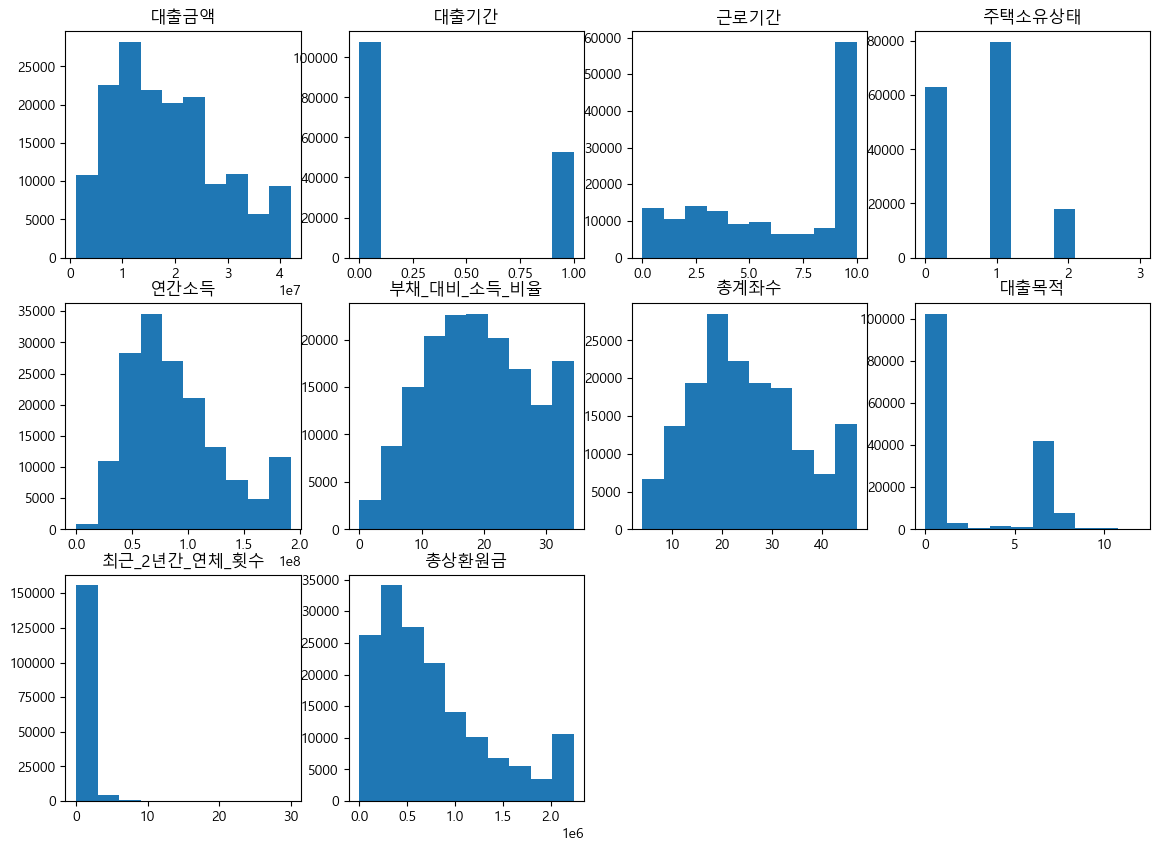

In [28]:
plt.figure(figsize=(14,10))

for i in range(1,11):
    plt.subplot(3,4,i)
    plt.hist(df[num_col[i-1]])
    plt.title(num_col[i-1])

- 대출금액, 근로기간, 총계좌수를 제외한 대부분의 feature가 0 부근에 몰려있다
- 데이터를 살펴보면 평균, 중위값에 비해 최대값이 굉장히 크다, 대부분의 데이터 값과 최대값의 차이가 크다

In [44]:
df['연간소득'].max(), round(df['연간소득'].mean()), df['연간소득'].median()

(10800000000, 94141547, 78000000.0)

#### - featrue 별 violinplot

In [35]:
def show_violinplot(df, columns):
    
    target_list = df['대출등급'].value_counts().index.tolist()
    target_list.sort()
    
    for col in columns:
        plt.figure(figsize=(10,4))
        sns.violinplot(x='대출등급', y=col, data=df, 
                       order=target_list)
        plt.show()

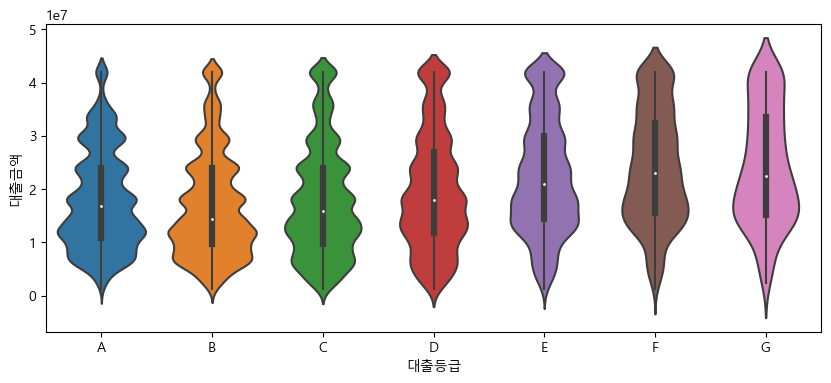

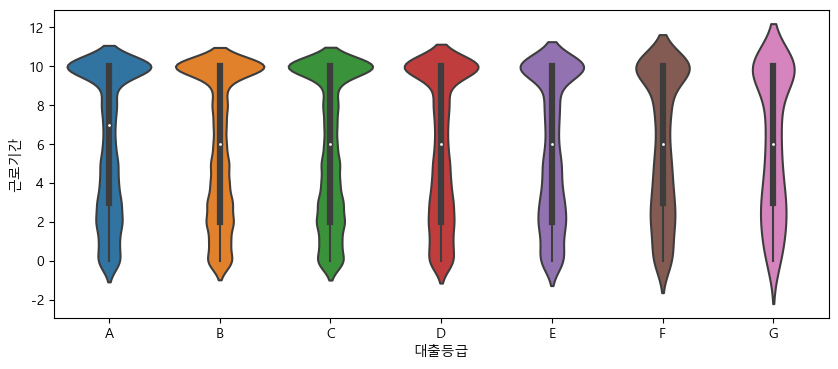

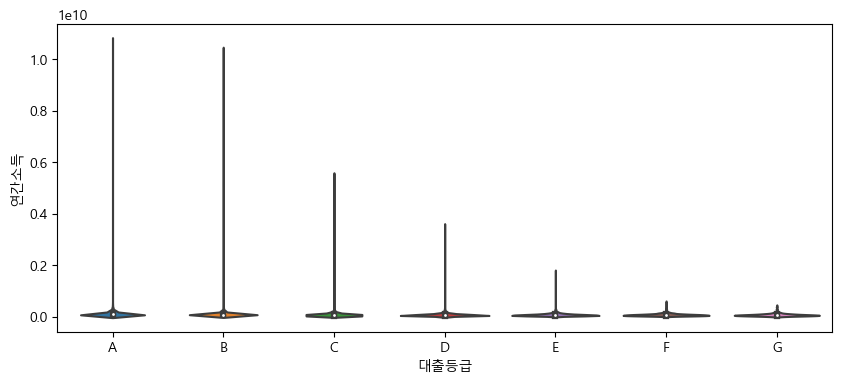

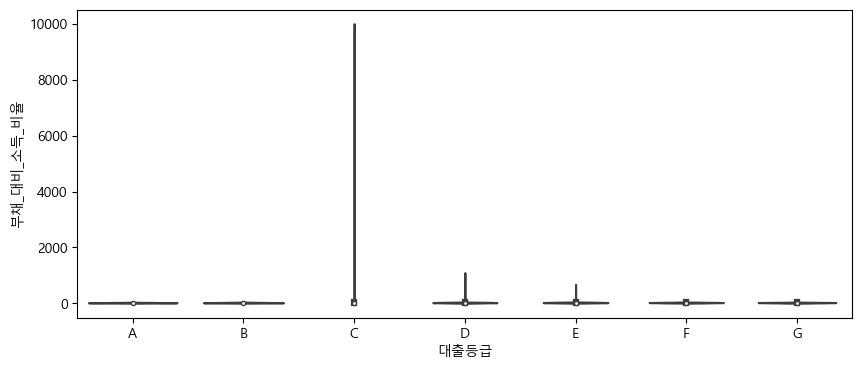

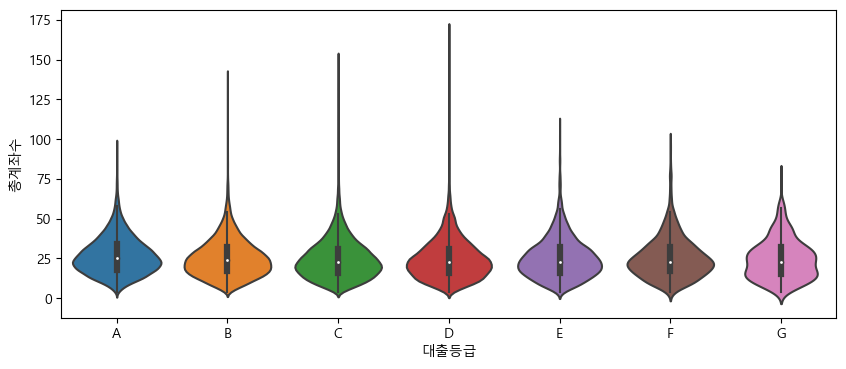

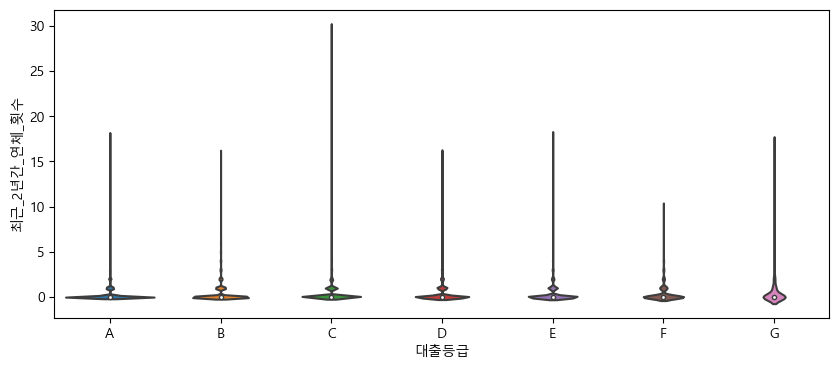

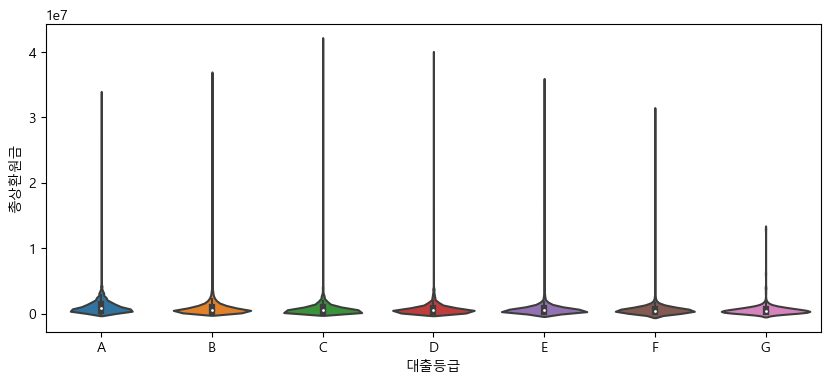

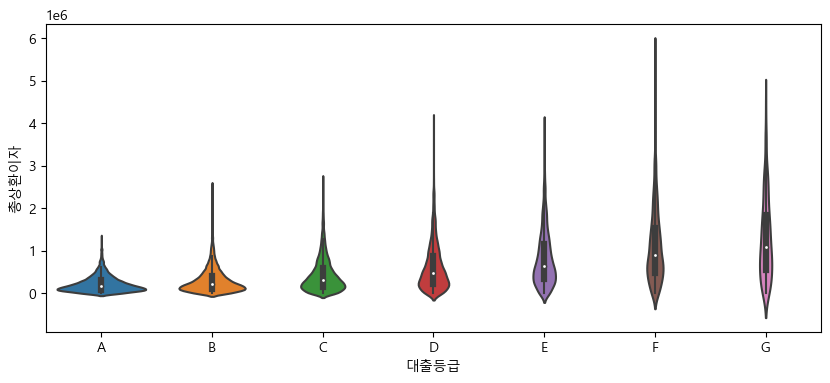

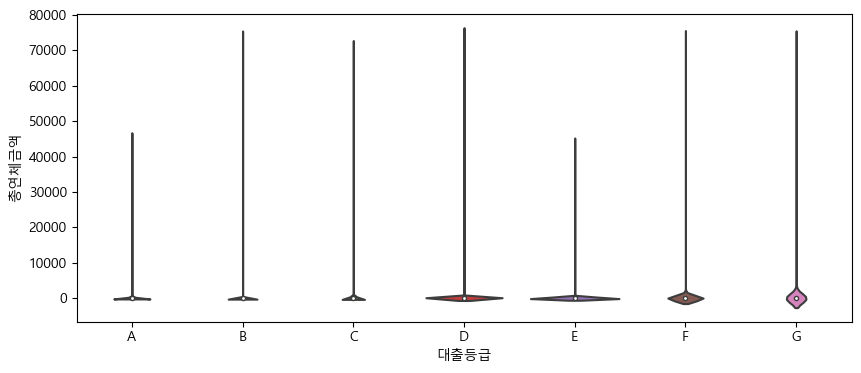

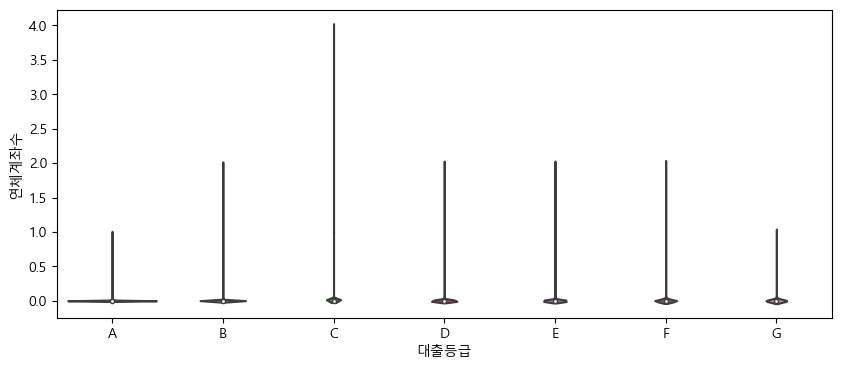

In [36]:
show_violinplot(df,num_col)

#### - featrue 별 distplot

In [ ]:
conAB = df['대출등급'].isin(['A','B'])
conCD = df['대출등급'].isin(['C','D'])
conEFG = df['대출등급'].isin(['E','F','G'])

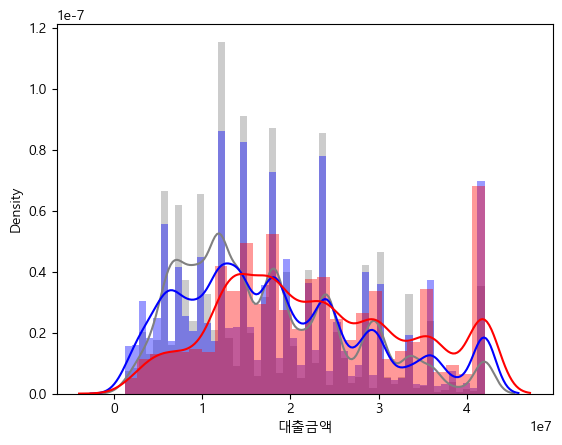

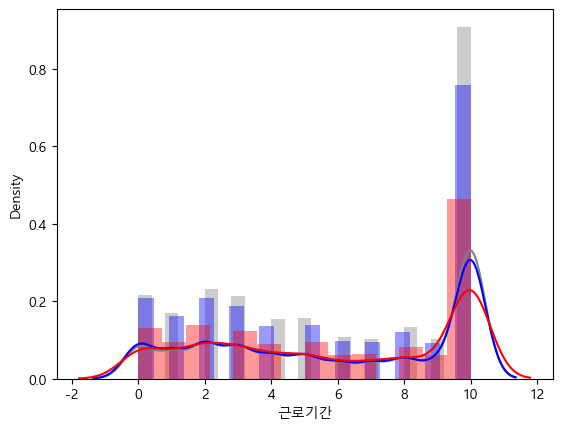

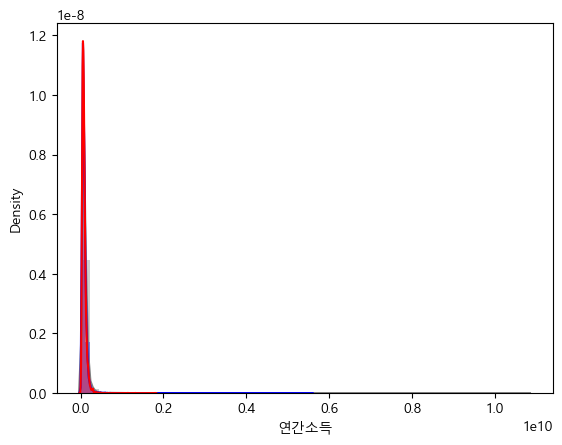

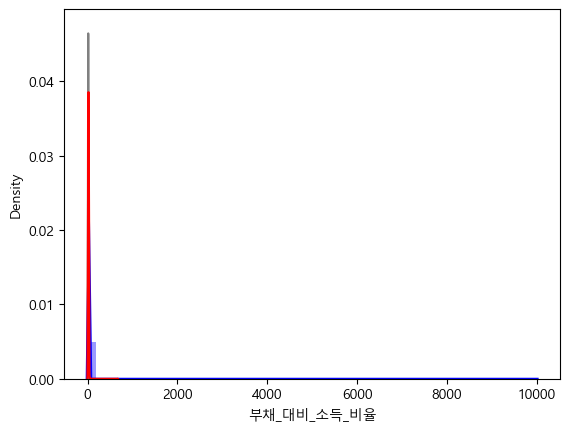

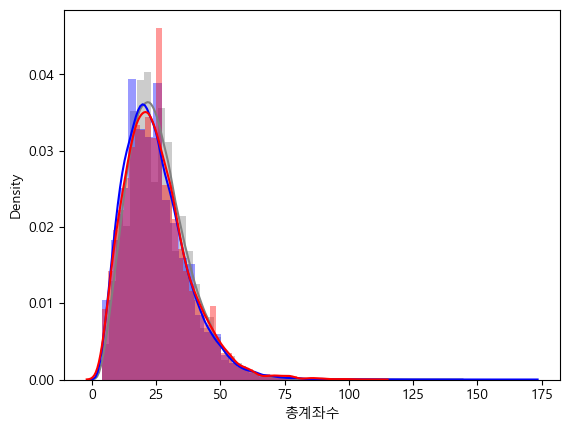

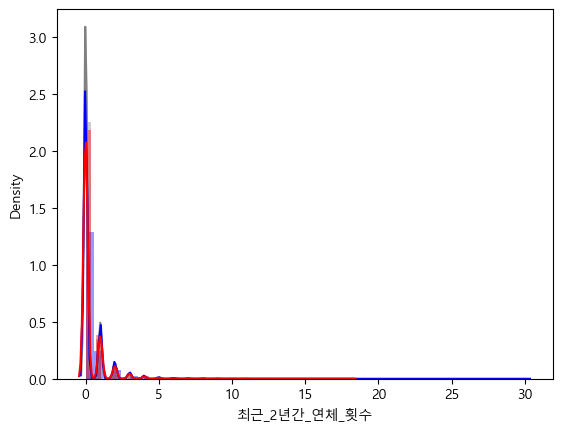

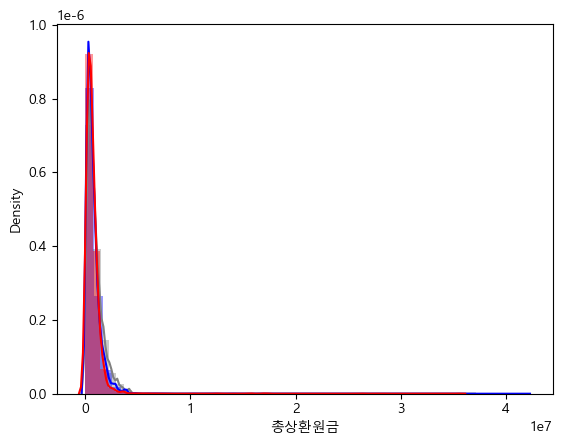

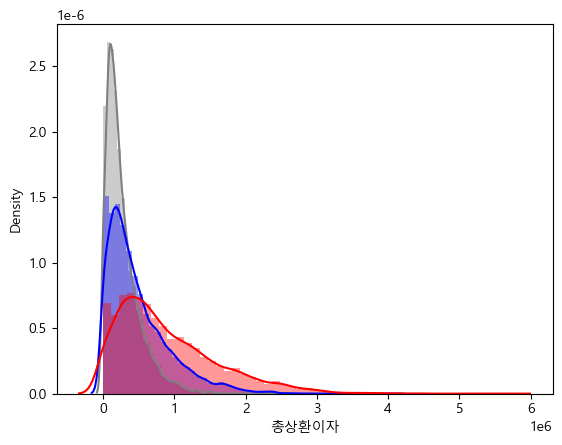

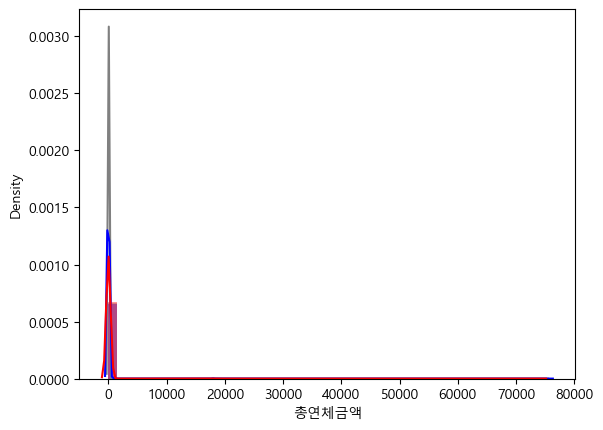

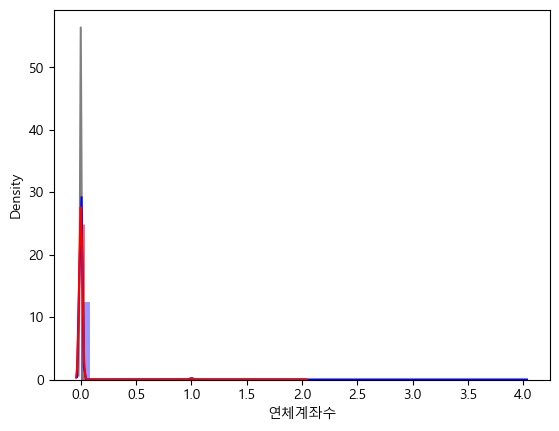

In [51]:
for col in num_col:
    sns.distplot(df[conAB][col], label='AB', color='gray')
    sns.distplot(df[conCD][col], label='CD', color='blue')
    sns.distplot(df[conEFG][col], label='EFG', color='red')
    plt.show()

- 대출 금액
> 높은 등급구간에서는 소액대출<br>
> 낮은 등급 구간에서는 비교적 고액대출의 비율이 높다


- 근로기간
> E,F,G 등급에서 장기 근로자의 비율이 매우 낮아짐


- 총상환이자
> 당연히 높은 신용등급의 사람들의 이자 상환 금액이 낮다<br>
> 상대적으로 낮은 금액을 대출받기 때문, 이 컬럼은 비율로 수정이 필요

## 2) 카테고리형 특성 분포 확인

In [55]:
df.dtypes[df.dtypes=='object']

ID        object
대출기간      object
주택소유상태    object
대출목적      object
대출등급      object
dtype: object

In [7]:
cate_col = ['대출기간','주택소유상태','대출목적']

In [8]:
def show_bar_chart(df, columns):        
    for col in columns:
        chart = sns.catplot(x=col, col='대출등급',data=df,
                            kind='count')
        chart.set_xticklabels(rotation=65)

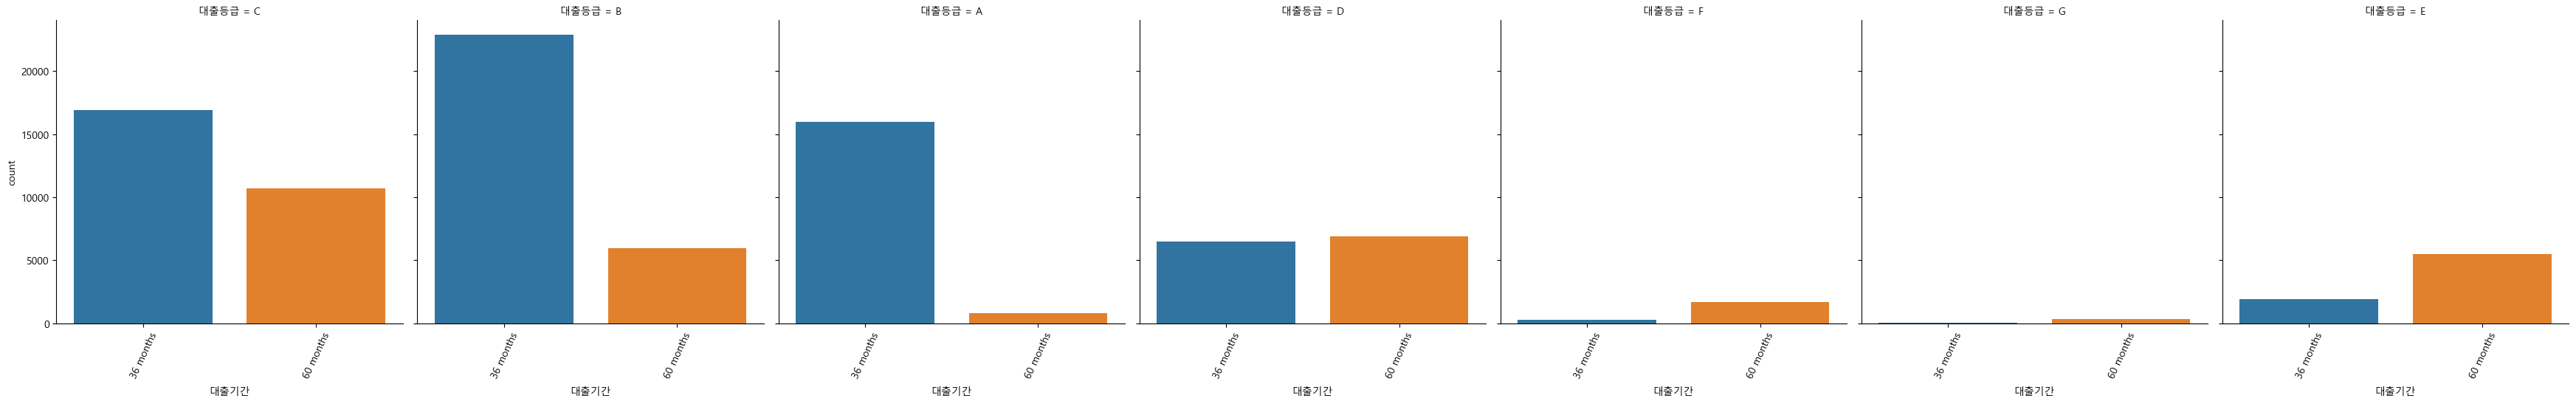

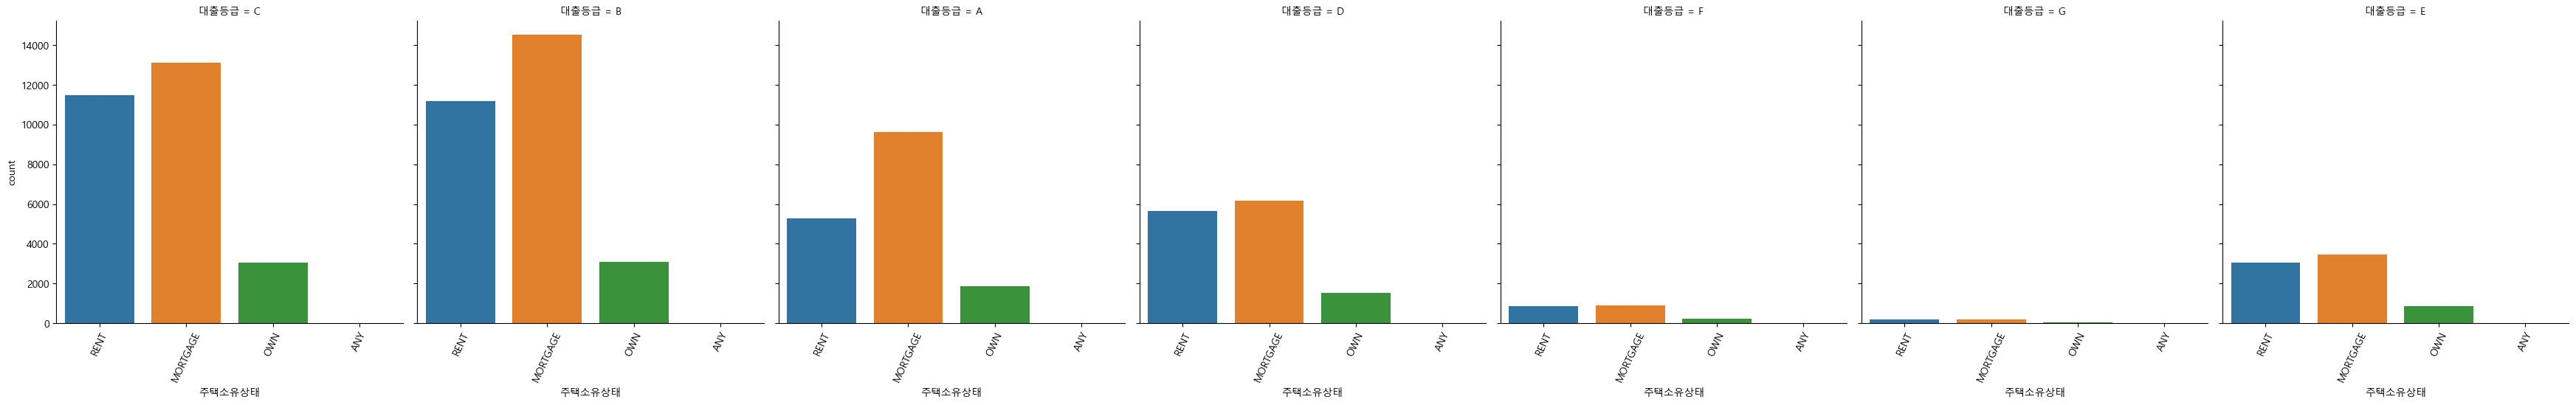

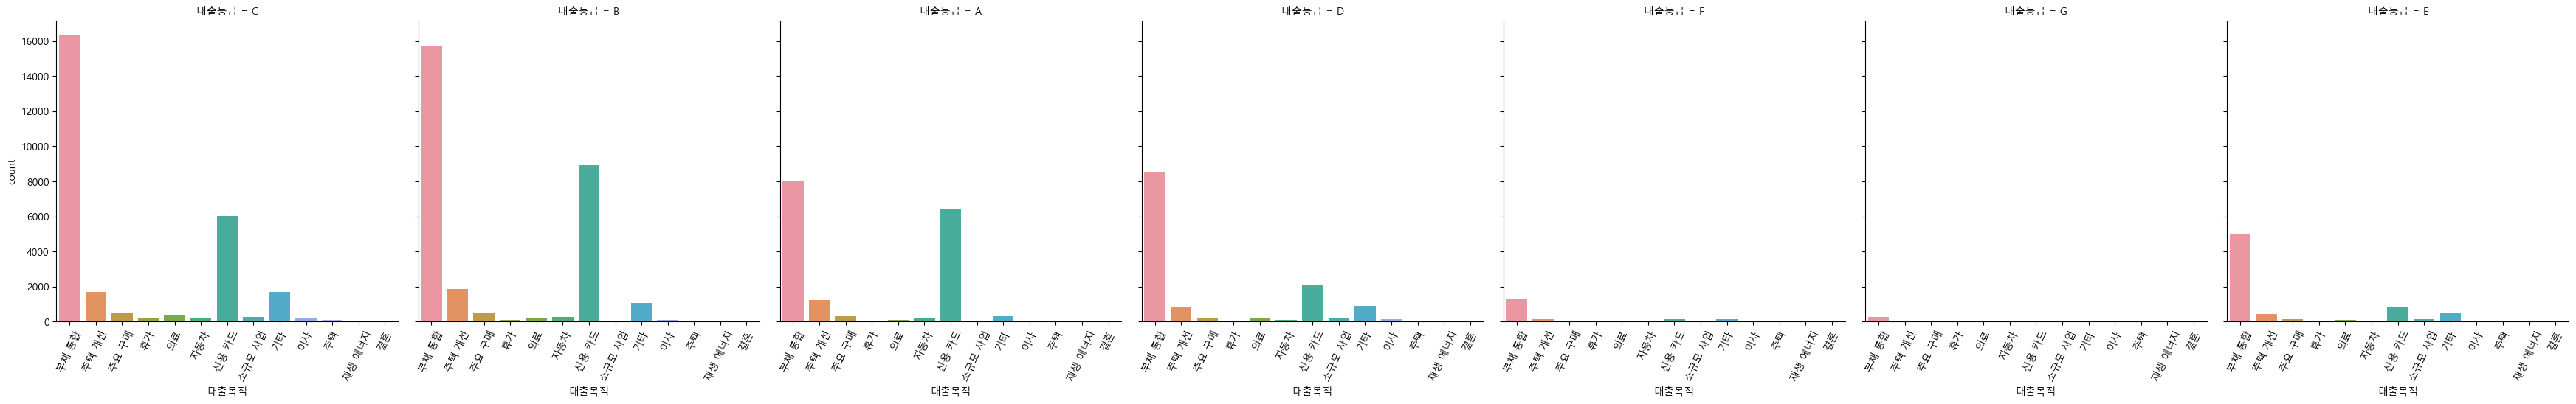

In [9]:
show_bar_chart(df, cate_col)

- 대출기간은 높은 등급에서 36개월이고 D등급 이상의 낮은 등급으로 가면서 60개월의 비율이 역전된다
- 주택 소유상태는 높은 등급에서 주택대출의 비율이 크고 낮은 등급으로 갈수록 렌트와 주택대출의 비율이 비슷해진다 자가인 비율은 낮은 등급에서 더 크다

## 3) feature preprocessing

In [8]:
num_col = df.dtypes[df.dtypes != 'object'].index.tolist()
df[num_col].head()

,대출금액,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,6.0,72000000,18.90,15,0,0,0.0,0.0,0.0
1,14400000,10.0,130800000,22.33,21,0,373572,234060.0,0.0,0.0
2,12000000,5.0,96000000,8.60,14,0,928644,151944.0,0.0,0.0
3,14400000,8.0,132000000,15.09,15,0,325824,153108.0,0.0,0.0
4,18000000,NaN,71736000,25.39,19,0,228540,148956.0,0.0,0.0


In [46]:
a = df['총상환원금']/(df['총상환이자']+1)
b = a*df['부채_대비_소득_비율']

In [51]:
a.mean(), df['부채_대비_소득_비율'].mean()

(275.7956408713518, 19.13747904867073)

<AxesSubplot:>

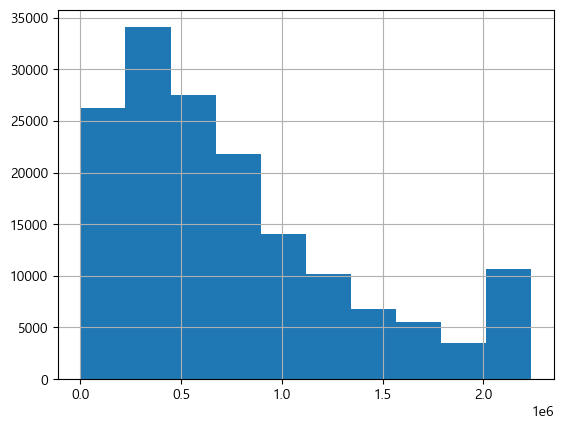

In [25]:
df['총상환원금'].hist()

In [24]:
a.max()

inf

In [21]:
a.max()

inf

- '대출금액','근로기간'을 제외한 다른 수치형 컬럼에 대한 데이터 처리 필요
- '총상환원금','총상환이자' 비율 항목 추가
- '총연체금액','최근2년연체횟수'에 대해서 0,1 카테고리 추가 바람

#### - 수치 상한값 조정

In [9]:
modi_col = ['연간소득','총계좌수','부채_대비_소득_비율','총상환원금','총상환이자',]

In [10]:
def upper_limit_95(df, columns):
    for col in columns:
        per95 = df[col].quantile(0.95)
        df[col] = df[col].apply(lambda x : per95 if x > per95 else x)

In [11]:
upper_limit_95(df,modi_col)

#### - 카테고리 라벨 인코딩

In [12]:
col = ['대출기간', '주택소유상태', '대출목적']
for c in col:
    df[c] = pd.factorize(df[c])[0]

#### - 정수형 변경

In [13]:
df.dtypes[df.dtypes == 'float'].index.tolist()

['근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']

In [14]:
col = ['연간소득','총계좌수','총상환이자','총연체금액','연체계좌수',
       '최근_2년간_연체_횟수','총상환원금']
df[col] = df[col].astype(int)

In [47]:
# deci = False

# for data in df['최근_2년간_연체_횟수']:
#     if data %1 != 0 :
#         print('소수점 데이터 있음')
#         deci = True
#         break

# if not deci:
#     print('모두 정수 값')

모두 정수 값


## 4) add features 

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160491 entries, 0 to 64196
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            160491 non-null  object 
 1   대출금액          160491 non-null  int64  
 2   대출기간          160491 non-null  int64  
 3   근로기간          149446 non-null  float64
 4   주택소유상태        160491 non-null  int64  
 5   연간소득          160491 non-null  int32  
 6   부채_대비_소득_비율   160491 non-null  float64
 7   총계좌수          160491 non-null  int32  
 8   대출목적          160491 non-null  int64  
 9   최근_2년간_연체_횟수  160491 non-null  int32  
 10  총상환원금         160491 non-null  int32  
 11  총상환이자         160491 non-null  int32  
 12  총연체금액         160491 non-null  int32  
 13  연체계좌수         160491 non-null  int32  
 14  대출등급          96294 non-null   object 
dtypes: float64(2), int32(7), int64(4), object(2)
memory usage: 15.3+ MB


- '총연체금액', '연체계좌수' 카테고리 추가

In [16]:
def feature_create(df):
    qu3 = int(df['대출금액'].quantile(0.3))
    df['대출금액상한액지정'] = df['대출금액'].apply(lambda x : qu3 if x > qu3 else x)
    
    df['장기근로자'] = df['근로기간'].apply(lambda x: 0 if x < 10 else 1)
    
    df['연체여부'] = df['총연체금액'].apply(lambda x : 1 if x!=0 else 0)
    df['연체계좌여부'] = df['연체계좌수'].apply(lambda x : 1 if x!=0 else 0)
    
    df['상환비율'] = df['총상환원금']/df['대출금액']
    df['상환이자비율'] = df['총상환이자']/df['대출금액']
    df['상환원금이자비율'] = df['총상환원금']/df['총상환이자']
    
    return df

In [17]:
feature_create(df)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,...,총연체금액,연체계좌수,대출등급,대출금액상한액지정,장기근로자,연체여부,연체계좌여부,상환비율,상환이자비율,상환원금이자비율
0,TRAIN_00000,12480000,0,6.0,0,72000000,18.90,15,0,0,...,0,0,C,12000000,0,0,0,0.000000,0.000000,NaN
1,TRAIN_00001,14400000,1,10.0,1,130800000,22.33,21,1,0,...,0,0,B,12000000,1,0,0,0.025943,0.016254,1.596052
2,TRAIN_00002,12000000,0,5.0,1,96000000,8.60,14,0,0,...,0,0,A,12000000,0,0,0,0.077387,0.012662,6.111752
3,TRAIN_00003,14400000,0,8.0,1,132000000,15.09,15,0,0,...,0,0,C,12000000,0,0,0,0.022627,0.010632,2.128066
4,TRAIN_00004,18000000,1,NaN,0,71736000,25.39,19,2,0,...,0,0,B,12000000,1,0,0,0.012697,0.008275,1.534279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,TEST_64192,30000000,0,3.0,1,78000000,22.08,27,0,2,...,0,0,NaN,12000000,0,0,0,0.043584,0.025446,1.712819
64193,TEST_64193,30000000,1,10.0,1,109200000,12.06,26,0,0,...,0,0,NaN,12000000,1,0,0,0.032020,0.041508,0.771420
64194,TEST_64194,6120000,0,10.0,0,39600000,28.80,33,0,0,...,0,0,NaN,6120000,1,0,0,0.021490,0.013216,1.626113
64195,TEST_64195,11520000,0,10.0,1,66000000,25.44,41,0,1,...,0,0,NaN,11520000,1,0,0,0.116279,0.052246,2.225616


#### - train, test 분리

In [18]:
train = copy2[~copy2['대출등급'].isnull()]
test = copy2[copy2['대출등급'].isnull()].drop('대출등급',axis=1)
print(train.shape, test.shape)

(96294, 19) (64197, 18)


## 5) lgbm train

In [19]:
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split

In [20]:
X = train.drop(['ID','대출등급'], axis=1)
y = train['대출등급']

xt, xv, yt, yv = train_test_split(X,y,
                                 test_size = 0.25,
                                 random_state = 2024)

xt.shape, xv.shape

((72220, 17), (24074, 17))

In [21]:
params = {'n_estimators': 1000,
          'max_depth': 10, 
          'num_leaves': 41, 
          'min_child_samples': 36, 
          'min_child_weight': 15, 
          'learning_rate': 0.038271390011357716, 
          'subsample': 0.8240659327203188, 
          'colsample_bytree': 0.1991348172483006, 
          'reg_alpha': 1.814111538332781, 
          'reg_lambda': 3.115892763637826,
          'verbose': -1,
         }

In [22]:
model = LGBMClassifier(**params)
model.fit(xt, yt, eval_set = [(xt,yt),(xv,yv)],
          eval_metric = 'multi_logloss',
          callbacks = [lgb.early_stopping(stopping_rounds=50), 
                      lgb.log_evaluation(period=100)])

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.45346	valid_1's multi_logloss: 0.45803
[200]	training's multi_logloss: 0.270369	valid_1's multi_logloss: 0.278808
[300]	training's multi_logloss: 0.210299	valid_1's multi_logloss: 0.223707
[400]	training's multi_logloss: 0.182801	valid_1's multi_logloss: 0.202163
[500]	training's multi_logloss: 0.165479	valid_1's multi_logloss: 0.190573
[600]	training's multi_logloss: 0.154884	valid_1's multi_logloss: 0.185232
[700]	training's multi_logloss: 0.1465	valid_1's multi_logloss: 0.181942
[800]	training's multi_logloss: 0.139887	valid_1's multi_logloss: 0.180229
[900]	training's multi_logloss: 0.134305	valid_1's multi_logloss: 0.178966
[1000]	training's multi_logloss: 0.129956	valid_1's multi_logloss: 0.178571
Did not meet early stopping. Best iteration is:
[992]	training's multi_logloss: 0.13026	valid_1's multi_logloss: 0.17855


LGBMClassifier(colsample_bytree=0.1991348172483006,
               learning_rate=0.038271390011357716, max_depth=10,
               min_child_samples=36, min_child_weight=15, n_estimators=1000,
               num_leaves=41, reg_alpha=1.814111538332781,
               reg_lambda=3.115892763637826, subsample=0.8240659327203188,
               verbose=-1)

In [27]:
# [996]	training's multi_logloss: 0.111666	valid_1's multi_logloss: 0.17243 전체
# 대출금액, 연간소득, 상환이자비율, 상환원금이자비율, 총계좌수, 상환비율

# [992]	training's multi_logloss: 0.13026	valid_1's multi_logloss: 0.17855
# 상환비율, 상환이자비율, 부채대비소득비율, 대출금액, 연간소득

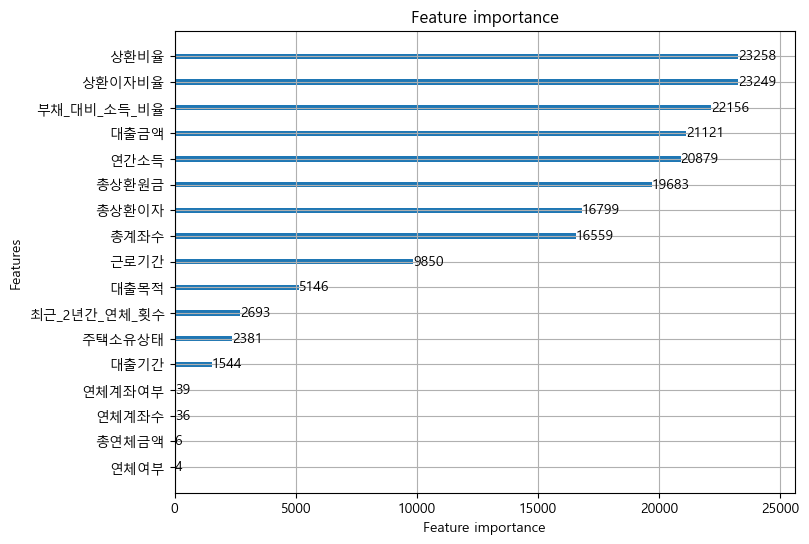

In [23]:
from lightgbm import plot_importance
plot_importance(model, figsize=(8, 6))
plt.show()

In [42]:
id_list = test['ID']
pred = model.predict(test.drop(['ID'],axis=1))

dic = {'ID' : id_list,
      '대출등급' : pred}
result = pd.DataFrame(dic)

In [43]:
result.to_csv('submit01.csv', index=False)

## 6) 수정 학습

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from sklearn.model_selection import cross_val_score, train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb
import optuna

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [29]:
def load_dataset():
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')
    all_df = pd.concat([train,test])
    return all_df

def to_num(value):
    try:
        return int(value.split()[0])
    except ValueError:
        if value in ('10+ years','10+yea|rs'):
            return 10
        elif value in ('< 1 year','<1 year'):
            return 0
        else:
            return np.nan

def working_period_to_num(df):
    df['근로기간'] = df['근로기간'].apply(to_num)
    return df

def upper_limit_95(df, columns):
    for col in columns:
        per95 = df[col].quantile(0.95)
        df[col] = df[col].apply(lambda x : per95 if x > per95 else x)

def feature_preprocessing(df):
    
    # 상한설정
    limit_col = ['연간소득','총계좌수','부채_대비_소득_비율',
                 '총상환원금','총상환이자','상환원금이자비율',]
    upper_limit_95(df, limit_col)
    
    # 라벨 인코딩
    to_label_col = ['대출기간', '주택소유상태', '대출목적']
    for col in to_label_col:
        df[col] = pd.factorize(df[col])[0]
        
    # 불필요한 실수를 정수형으로    
    to_int_col = ['연간소득','총계좌수','총상환이자','총연체금액',
                  '연체계좌수','최근_2년간_연체_횟수','총상환원금']
    df[to_int_col] = df[to_int_col].astype(int)
    
    return df

def feature_create(df):

    #1
    df['연체여부'] = df['총연체금액'].apply(lambda x : 1 if x!=0 else 0)
    df['연체계좌여부'] = df['연체계좌수'].apply(lambda x : 1 if x!=0 else 0)
    
    df['상환비율'] = df['총상환원금']/df['대출금액']
    df['상환이자비율'] = df['총상환이자']/df['대출금액']
    df['상환원금이자비율'] = df['총상환원금']/(df['총상환이자']+1)
    
    #2
    qu3 = int(df['대출금액'].quantile(0.3))
    df['대출금액상한액지정'] = df['대출금액'].apply(lambda x : qu3 if x > qu3 else x)
    
    df['장기근로자'] = df['근로기간'].apply(lambda x: 0 if x < 10 else 1)
    
    #4
    df['월상환금액'] = df['대출금액']/df['대출기간'].apply(lambda x : 36 if x == ' 36 months' else 60)
    
    return df

def dataset_line():
    
    df = load_dataset()
    working_period_to_num(df)
    feature_create(df)
    feature_preprocessing(df)
    
    return df

def model_train(df):
    train = df[~df['대출등급'].isnull()]
    test = df[df['대출등급'].isnull()].drop('대출등급',axis=1)
    
    X = train.drop(['ID','대출등급'], axis=1)
    y = train['대출등급']

    xt, xv, yt, yv = train_test_split(X,y,
                                     test_size = 0.25,
                                     random_state = 2024)
    
    params = {'n_estimators': 1000,
              'max_depth': 16, 
              'num_leaves': 40, 
              'min_child_samples': 11, 
              'min_child_weight': 4, 
              'learning_rate': 0.03481404509271331, 
              'subsample': 0.8887993725651923, 
              'colsample_bytree': 0.37138221165051943, 
              'reg_alpha': 2.5049384900271203, 
              'reg_lambda': 7.081039316217577}

    # params = {'n_estimators': 1000,
    #           'max_depth': 17, 
    #           'num_leaves': 42, 
    #           'min_child_samples': 92, 
    #           'min_child_weight': 14, 
    #           'learning_rate': 0.049901096346189666, 
    #           'subsample': 0.9877380612433788, 
    #           'colsample_bytree': 0.5048349295330024, 
    #           'reg_alpha': 4.891246428501365, 
    #           'reg_lambda': 1.0025617453313647}
    
    model = LGBMClassifier(**params, verbose = -1)
    model.fit(xt, yt, eval_set = [(xt,yt),(xv,yv)],
              eval_metric = 'multi_logloss',
              callbacks = [lgb.early_stopping(stopping_rounds=50), 
                          lgb.log_evaluation(period=100)])
    
    return model, test

In [30]:
df = dataset_line()
model, test = model_train(df)

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.198759	valid_1's multi_logloss: 0.206949
[200]	training's multi_logloss: 0.136298	valid_1's multi_logloss: 0.153996
[300]	training's multi_logloss: 0.118791	valid_1's multi_logloss: 0.146783
[400]	training's multi_logloss: 0.107171	valid_1's multi_logloss: 0.143841
[500]	training's multi_logloss: 0.0986086	valid_1's multi_logloss: 0.142665
[600]	training's multi_logloss: 0.0917327	valid_1's multi_logloss: 0.14208
[700]	training's multi_logloss: 0.0860563	valid_1's multi_logloss: 0.141952
Early stopping, best iteration is:
[672]	training's multi_logloss: 0.0875299	valid_1's multi_logloss: 0.141873


In [75]:
# [779]	training's multi_logloss: 0.118289	valid_1's multi_logloss: 0.169803
# [979]	training's multi_logloss: 0.106241	valid_1's multi_logloss: 0.165862

# [837]	training's multi_logloss: 0.11217	valid_1's multi_logloss: 0.166376 # 새로운 특성에 대해서
# [815]	training's multi_logloss: 0.104209	valid_1's multi_logloss: 0.164431 새로운 파라미터
# [684]	training's multi_logloss: 0.0900251	valid_1's multi_logloss: 0.140832 (제출0.91) 상환비율 24, 부채대비 17, 상환원금이자 16

# [674]	training's multi_logloss: 0.0888876	valid_1's multi_logloss: 0.141781 # 세번째 피처 상환비율 22, 상환이자비율 17, 부채대비 16

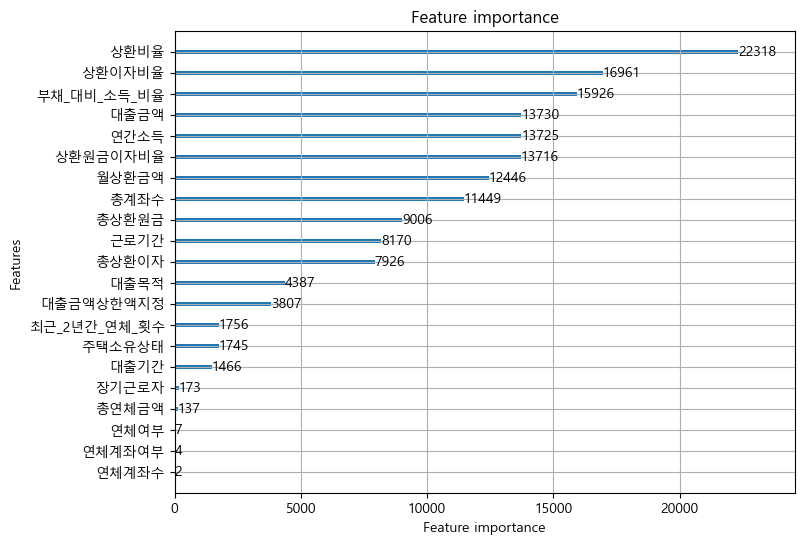

In [31]:
from lightgbm import plot_importance
plot_importance(model, figsize=(8, 6))
plt.show()

In [8]:
id_list = test['ID']
pred = model.predict(test.drop(['ID'],axis=1))

In [9]:
dic = {'ID' : id_list,
      '대출등급' : pred}
result = pd.DataFrame(dic)

In [11]:
result.to_csv('submit03.csv',index=False)

#### - XGB

- 반드시 label 숫자로 넣어야 됨!!!
- lgbm은 문자도 가능

In [24]:
    train = df[~df['대출등급'].isnull()]
    test = df[df['대출등급'].isnull()].drop('대출등급',axis=1)
    
    X = train.drop(['ID','대출등급'], axis=1)
    y = train['대출등급']

In [32]:
X.shape, y.shape

((96294, 21), (96294,))

In [39]:
label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E':4, 'F':5, 'G':6}
y = y.map(label_mapping)

print(y)

0        2
1        1
2        0
3        2
4        1
        ..
96289    2
96290    4
96291    0
96292    3
96293    2
Name: 대출등급, Length: 96294, dtype: int64


In [41]:
def objective_xgb(trial):

    params = {'objective': 'multiclass', 'num_class': 7, 
              'n_estimators': trial.suggest_int('n_estimators', 350, 600),
              'max_depth': trial.suggest_int('max_depth',10,20),
              'num_leaves' : trial.suggest_int('num_leaves',24,64),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
              'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
              'subsample': trial.suggest_float('subsample', 0.5, 1.0),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1),
              'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
              'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 50),
              'random_state': 2024
             }

    model = XGBClassifier(**params, verbose=-1)

    scores = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss')

    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb , n_trials=5) # Adjust the number of trials to 100-1000
best_params2 = study.best_params
print('Best params:' , best_params2)

[I 2024-02-04 23:14:34,811] A new study created in memory with name: no-name-6808f7f5-29f4-4147-93a0-70650eff6005
[I 2024-02-04 23:16:38,483] Trial 0 finished with value: 0.16459014341434336 and parameters: {'n_estimators': 424, 'max_depth': 10, 'num_leaves': 50, 'min_child_samples': 13, 'min_child_weight': 44, 'learning_rate': 0.02525740677927902, 'subsample': 0.9671013774762446, 'colsample_bytree': 0.591949250505556, 'reg_alpha': 6.782950176833123, 'reg_lambda': 13.221626283317317}. Best is trial 0 with value: 0.16459014341434336.
[I 2024-02-04 23:18:45,041] Trial 1 finished with value: 0.18293943682211747 and parameters: {'n_estimators': 459, 'max_depth': 18, 'num_leaves': 37, 'min_child_samples': 127, 'min_child_weight': 38, 'learning_rate': 0.025702565590453738, 'subsample': 0.6587335998732495, 'colsample_bytree': 0.3609757095994707, 'reg_alpha': 7.685349327669194, 'reg_lambda': 20.22905590119017}. Best is trial 0 with value: 0.16459014341434336.
[I 2024-02-04 23:20:48,746] Trial 

Best params: {'n_estimators': 558, 'max_depth': 10, 'num_leaves': 28, 'min_child_samples': 67, 'min_child_weight': 34, 'learning_rate': 0.038408392029227266, 'subsample': 0.754621037616473, 'colsample_bytree': 0.3800043435885754, 'reg_alpha': 1.2716832942382994, 'reg_lambda': 28.04314070900918}


In [ ]:
xgb_params = {'max_depth': 10, 
          'num_leaves': 28, 
          'min_child_samples': 67, 
          'min_child_weight': 34, 
          'learning_rate': 0.038408392029227266, 
          'subsample': 0.754621037616473, 
          'colsample_bytree': 0.3800043435885754, 
          'reg_alpha': 1.2716832942382994, 
          'reg_lambda': 28.04314070900918}